# **Introduction**

In the world of insurance, understanding your customers and their needs is crucial for success. My client, an insurance company, has provided health insurance to its customers and is now seeking to expand its offerings to include vehicle insurance. To do so, they need to identify which of their policyholders from the past year would also be interested in this new type of insurance.

As a data scientist, I have been tasked to build a model that predicts which customers are likely to be interested in vehicle insurance based on their demographic information, vehicle details, policy data, and more. This will enable my client to tailor their marketing strategies and better serve their customers while optimizing their revenue.

# **Libraries**
Importing necessary libraries and packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score,recall_score,\
f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# **Data Importing & Preprocessing**
Loading the data and preparing it for machine learning

In [ ]:
#mounting my google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#loading the train data
vehInsuranceTrain = pd.read_csv("/content/sample_data/train.csv")

In [ ]:
#inspecting the shape of the data
vehInsuranceTrain.shape

(381109, 12)

In [ ]:
vehInsuranceTrain.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


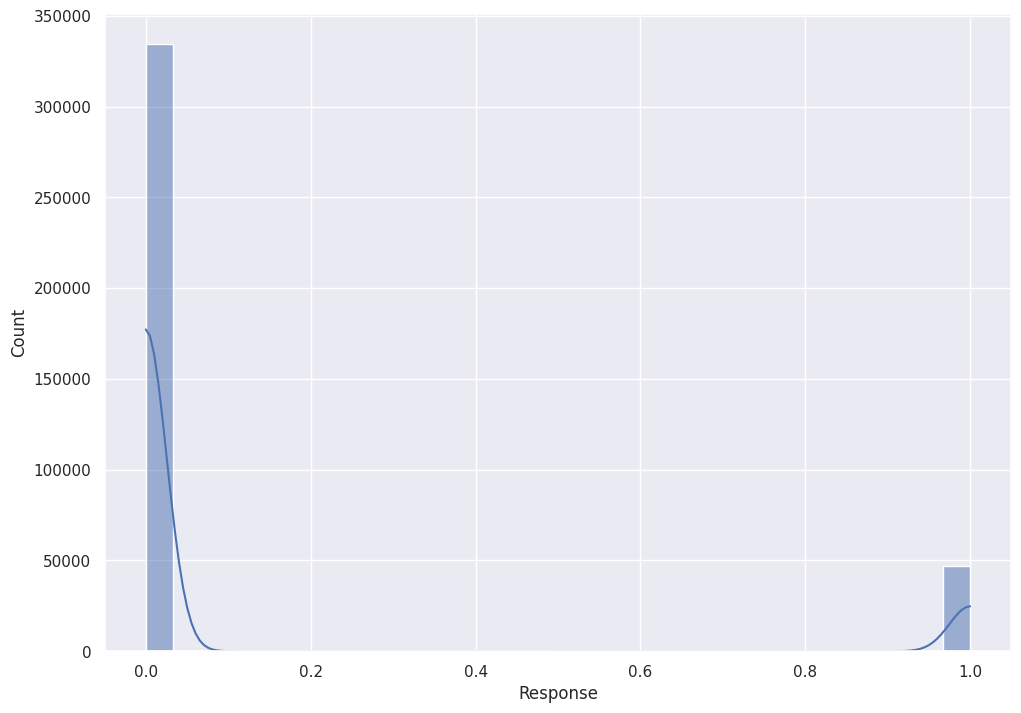

In [ ]:
#inspecting the distribution of the target variable
sns.set(rc={'figure.figsize': (11.7, 8.28)})
sns.histplot(data=vehInsuranceTrain, x="Response", bins=30, kde="True")
plt.show()

In [ ]:
#checking the unique counts of the target variable
vehInsuranceTrain["Response"].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [ ]:
#defining a dictionary to map the numerical values of the target varaible to the class name
#Class 0 is Not_Interested and Class 1 is Interested
classNames = {0: "Not_Interested", 1: "Interested"}

In [ ]:
#Checking to see there are no missing values
vehInsuranceTrain.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
#checking correlation among variables with the target variable
corr = vehInsuranceTrain.corr()
corr

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,0.001561,-0.000564,-0.000572,0.002457,0.003027,-0.002837,-0.000630,-0.001368
Age,0.001561,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.003027,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.000630,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,-0.001368,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


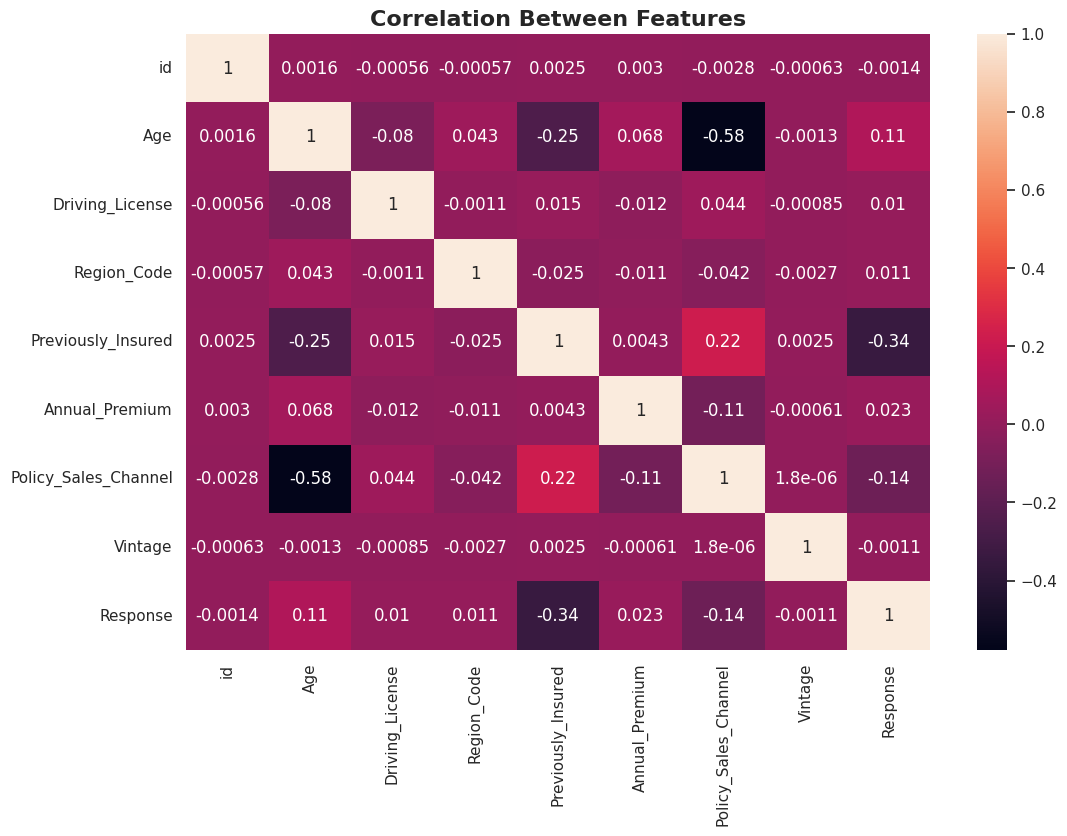

In [ ]:
#plotting a heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data=corr, annot=True)
plt.title("Correlation Between Features", fontsize=16, fontweight="bold")
plt.show()

In [ ]:
#instantiating the label encoder
labelEncoder = LabelEncoder()

#applying LabelEncoder to the categorical columns of the train data
vehInsuranceTrain["Gender"] = labelEncoder.fit_transform(vehInsuranceTrain["Gender"])
vehInsuranceTrain["Vehicle_Age"] = labelEncoder.fit_transform(vehInsuranceTrain["Vehicle_Age"])
vehInsuranceTrain["Vehicle_Damage"] = labelEncoder.fit_transform(vehInsuranceTrain["Vehicle_Damage"])

In [ ]:
#checking to see changes have been made
vehInsuranceTrain.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,0,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


In [ ]:
#loading the test data
vehInsuranceTest = pd.read_csv("/content/sample_data/test.csv")
vehInsuranceTest.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [ ]:
#inspecting the shape of the test data
vehInsuranceTest.shape

(127037, 11)

In [ ]:
#checking to see if any missing values in the test data
vehInsuranceTest.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [ ]:
#applying LabelEncoder to the categorical columns of the test data
vehInsuranceTest["Gender"] = labelEncoder.fit_transform(vehInsuranceTest["Gender"])
vehInsuranceTest["Vehicle_Age"] = labelEncoder.fit_transform(vehInsuranceTest["Vehicle_Age"])
vehInsuranceTest["Vehicle_Damage"] = labelEncoder.fit_transform(vehInsuranceTest["Vehicle_Damage"])

In [ ]:
#checking to see changes have been made in the test data
vehInsuranceTest.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,1,25,1,11.0,1,1,0,35786.0,152.0,53
1,381111,1,40,1,28.0,0,0,1,33762.0,7.0,111
2,381112,1,47,1,28.0,0,0,1,40050.0,124.0,199
3,381113,1,24,1,27.0,1,1,1,37356.0,152.0,187
4,381114,1,27,1,28.0,1,1,0,59097.0,152.0,297


In [ ]:
#splitting the train data into features and target variables
X = vehInsuranceTrain.drop("Response", axis=1)
y = vehInsuranceTrain["Response"]

In [ ]:
#splitting the features and target variables into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=25)

In [ ]:
#scaling the features applying standard scaler
scaler = StandardScaler()

#applying the scaler to the X_train, X_valid
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

#applying the scaler to the test data
X_test = vehInsuranceTest
X_test = scaler.transform(X_test)

In [ ]:
#inspecting the shape of the split data
display(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(304887, 11)

(76222, 11)

(304887,)

(76222,)

## **Hyperparameters Tuning**
Training the models with different hyperparameters and checking for the best hyperparameters to build the models with.

DecisionTreeClassifier

In [ ]:
#creating an instance of the DecisionTreeClassifier
dTree = DecisionTreeClassifier()

#defining the hyperparameters to be tuned
param_grid = {
    'class_weight': [None, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

#creating the scoring function
scoring = {'AUC': make_scorer(roc_auc_score),
           'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

#creating a GridSearchCV object with the DecisionTreeClassifier and the hyperparameter grid
grid_search = GridSearchCV(dTree, param_grid, cv=5, scoring=scoring, n_jobs=-1, refit="AUC")

#fitting the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, {0: 1, 1: 2}, {0: 1, 1: 3},
                                          {0: 1, 1: 4}, {0: 1, 1: 5}],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score), 'accuracy': 'accuracy',
                      'f1': 'f1', 'precision': 'precision',
                      'recall': 'recall'})

In [ ]:
#printing the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'class_weight': {0: 1, 1: 5}, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Score: 0.6930306015451573


In [ ]:
print(grid_search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_class_weight', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1',

In [ ]:
#getting the indices of the sorted mean_test_score array in descending order
sorted_indices = np.argsort(grid_search.cv_results_['mean_test_AUC'])[::-1]

# loop through the sorted indices to find the next best parameters
for i in sorted_indices:
    if grid_search.cv_results_['params'][i] != grid_search.best_params_:
        print("Next Best Hyperparameters:", grid_search.cv_results_['params'][i])
        print("Next Best Score:", grid_search.cv_results_['mean_test_AUC'][i])
        break

Next Best Hyperparameters: {'class_weight': {0: 1, 1: 5}, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Next Best Score: 0.6919820845648952


Logistic Regression

In [ ]:
#creating an instance of the log reg
logReg = LogisticRegression()

#defining the hyperparameters to be tuned
param_grid = {'penalty': ['l2', 'l1'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': [None, 'balanced']}

#defining the scoring function with AUC and F1 metrics
scoring = {
    'AUC': make_scorer(roc_auc_score),
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'F1': 'f1'
}

#creating a GridSearchCV object with the SVM classifier and the hyperparameter grid
grid_search = GridSearchCV(logReg, param_grid, cv=5, scoring=scoring, n_jobs=-1, refit="AUC")

#fitting the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l2', 'l1']},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score), 'F1': 'f1',
                      'accuracy': 'accuracy', 'precision': 'precision',
                      'recall': 'recall'})

In [ ]:
# print the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Best Score: 0.7839449889053152


In [ ]:
# getting the indices of the sorted mean_test_score array in descending order
sorted_indices = np.argsort(grid_search.cv_results_['mean_test_AUC'])[::-1]

# loop through the sorted indices to find the next best parameters
for i in sorted_indices:
    if grid_search.cv_results_['params'][i] != grid_search.best_params_:
        next_score = grid_search.cv_results_['mean_test_AUC'][i]
        if not np.isnan(next_score):
            print("Next Best Hyperparameters:", grid_search.cv_results_['params'][i])
            print("Next Best Score:", next_score)
            break

Next Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}
Next Best Score: 0.7839449889053152


I performed hyperparameter tuning for two classification models, the decision tree classifier and logistic regression. For the decision tree classifier, I found the best hyperparameters to be a class weight of {0:1, 1:5}, max features of 'sqrt', min samples leaf of 4, and min samples split of 5 with a best score of 0.693. The next best parameters were very similar to the best parameters, with min samples split of 2 and a slightly lower score of 0.692.

For logistic regression, I found the best hyperparameters to be a regularization parameter (C) of 0.1, penalty of 'l2', and class weight of 'balanced' with a best score of 0.784. The next best parameters had a higher regularization parameter of 10 and the same penalty and class weight with an identical score of 0.784.

Overall, hyperparameter tuning is a crucial step in optimizing model performance and achieving the best possible accuracy. The results of mu analysis provide valuable insights into the best hyperparameters for the decision tree and logistic regression models. These best hyperparameters will be used to build and train the models for higher accuracy.

# **Model Building & Development**
Building and training the models with the hyperparameters chosen in the previous step


## Decision Tree Classifier

In [ ]:
dTree1 = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_features='log2', min_samples_leaf=4, min_samples_split=5, random_state=23)
dTree2 = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_features='log2', min_samples_leaf=4, min_samples_split=2, random_state=23)

In [ ]:
dTree1.fit(X_train, y_train)
dTree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_features='log2',
                       min_samples_leaf=4, random_state=23)

In [ ]:
dTreePred1 = dTree1.predict(X_valid)
dTreePred2 = dTree2.predict(X_valid)

In [ ]:
print(dTreePred1)
print(dTreePred2)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


Sample Decision Tree Classifier Predictions

In [ ]:
#Will the client be interested or not?
#getting index of y_valid sample
sample_index = np.where(y_valid == y_valid[212381])[0][0]

#getting the corresponding X_test sample
X_test_sample = X_test[sample_index].reshape(1, -1)

#making prediction
dTreePredict1 = dTree1.predict(X_test_sample)

#converting prediction to class name
className = classNames[dTreePredict1[0]]

print(y_valid[212381])
print(className)


1
Interested


In [ ]:
#Will the client be interested or not?

#getting index of y_valid sample
sample_index = np.where(y_valid == y_valid[316194])[0][0]

#getting the corresponding X_test sample
X_test_sample = X_test[sample_index].reshape(1, -1)

#making prediction
dTreePredict2 = dTree2.predict(X_test_sample)

#converting prediction to class name
className = classNames[dTreePredict2[0]]

print(y_valid[316194])
print(className)


0
Not_Interested


## Logistic Regression

In [ ]:
logReg1 = LogisticRegression(C=0.1, class_weight="balanced", penalty="l2", random_state=23)
logReg2 = LogisticRegression(C=10, class_weight="balanced", penalty="l2", random_state=23)

In [ ]:
logReg1.fit(X_train, y_train)
logReg2.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=23)

In [ ]:
logRegPred1 = logReg1.predict(X_valid)
logRegPred2 = logReg2.predict(X_valid)

In [ ]:
print(logRegPred1)
print(logRegPred2)

[0 0 1 ... 1 1 1]
[0 0 1 ... 1 1 1]


Sample Logistic Regression Predictions

In [ ]:
#Will the client be interested or not?
#getting index of y_valid sample
sample_index = np.where(y_valid == y_valid[212381])[0][0]

#getting the corresponding X_test sample
X_test_sample = X_test[sample_index].reshape(1, -1)

#making prediction
logRegPredict1 = logReg1.predict(X_test_sample)

#converting prediction to class name
className = classNames[logRegPredict1[0]]

print(y_valid[212381])
print(className)


1
Interested


In [ ]:
#getting index of y_valid sample
sample_index = np.where(y_valid == y_valid[78824])[0][0]

#getting the corresponding X_test sample
X_test_sample = X_test[sample_index].reshape(1, -1)

#making prediction
logRegPredict2 = logReg2.predict(X_test_sample)

#converting prediction to class name
className = classNames[logRegPredict2[0]]

print(y_valid[78824])
print(className)

0
Not_Interested


# Evaluation
Evaluating the performance of the different models on the test data using various metrics such as roc-auc, accuracy, precision, recall, f1 scores, and confusion matrix.

ROC-AUC

In [ ]:
#Evaluating the decision tree classifiers
print("Decision Tree 1 Classifier AUC:", roc_auc_score(y_valid, dTreePred1))
print("Decision Tree 2 Classifier AUC:", roc_auc_score(y_valid, dTreePred2))

Decision Tree 1 Classifier AUC: 0.6966293955507357
Decision Tree 2 Classifier AUC: 0.6966293955507357


In [ ]:
print("Logistic Regression AUC:", roc_auc_score(y_valid, logRegPred1))
print("Logistic Regression AUC:", roc_auc_score(y_valid, logRegPred2))

Logistic Regression AUC: 0.7852206736895498
Logistic Regression AUC: 0.7852206736895498


Accuracy

In [ ]:
print("Decision Tree Accuracy:", accuracy_score(y_valid, dTreePred1))
print("Decision Tree Accuracy:", accuracy_score(y_valid, dTreePred2))

Decision Tree Accuracy: 0.7642412951641259
Decision Tree Accuracy: 0.7642412951641259


In [ ]:
print("Logistic Regression Accuracy:", accuracy_score(y_valid, logRegPred1))
print("Logistic Regression Accuracy:", accuracy_score(y_valid, logRegPred2))

Logistic Regression Accuracy: 0.6402744614415785
Logistic Regression Accuracy: 0.6402744614415785


 Precision

In [ ]:
print("Decision Tree 1 Classifier Precision:", precision_score(y_valid, dTreePred1))
print("Decision Tree 2 Classifier Precision:", precision_score(y_valid, dTreePred2))

Decision Tree 1 Classifier Precision: 0.28443398588093927
Decision Tree 2 Classifier Precision: 0.28443398588093927


In [ ]:
print("Logistic Regression 1 Precision:", precision_score(y_valid, logRegPred1))
print("Logistic Regression 2 Precision:", precision_score(y_valid, logRegPred2))

Logistic Regression 1 Precision: 0.2516091764317544
Logistic Regression 2 Precision: 0.2516091764317544


Recall

In [ ]:
print("Decision Tree 1 Classifier Recall_score:", recall_score(y_valid, dTreePred1))
print("Decision Tree 2 Classifier Recall_score:", recall_score(y_valid, dTreePred2))

Decision Tree 1 Classifier Recall_score: 0.6070092958649428
Decision Tree 2 Classifier Recall_score: 0.6070092958649428


In [ ]:
print("Logistic Regression 1  Recall_score:", recall_score(y_valid, dTreePred1))
print("Logistic Regression 2 Recall_score:", recall_score(y_valid, dTreePred2))

Logistic Regression 1  Recall_score: 0.6070092958649428
Logistic Regression 2 Recall_score: 0.6070092958649428


F1_score

In [ ]:
print("Decision Tree 1 Classifier F1_Score:", f1_score(y_valid, dTreePred1))
print("Decision Tree 2 Classifier F1_score:", f1_score(y_valid, dTreePred2))

Decision Tree 1 Classifier F1_Score: 0.3873585162961953
Decision Tree 2 Classifier F1_score: 0.3873585162961953


In [ ]:
print("Logistic Regression 1 F1_Score:", f1_score(y_valid, logRegPred1))
print("Logistic Regression 1 F1_score:", f1_score(y_valid, logRegPred2))

Logistic Regression 1 F1_Score: 0.40019250541421475
Logistic Regression 1 F1_score: 0.40019250541421475


Confusion Matrix

In [ ]:
dTree1_cm =confusion_matrix(y_valid, dTreePred1)
dTree2_cm =confusion_matrix(y_valid, dTreePred2)

In [ ]:
display(dTree1_cm, dTree2_cm)

array([[52571, 14292],
       [ 3678,  5681]])

array([[52571, 14292],
       [ 3678,  5681]])

In [ ]:
log1_cm = confusion_matrix(y_valid, logRegPred1)
log2_cm = confusion_matrix(y_valid, logRegPred2)

In [ ]:
display(log1_cm, log2_cm)

array([[39656, 27207],
       [  212,  9147]])

array([[39656, 27207],
       [  212,  9147]])

Confusion Matrix Display

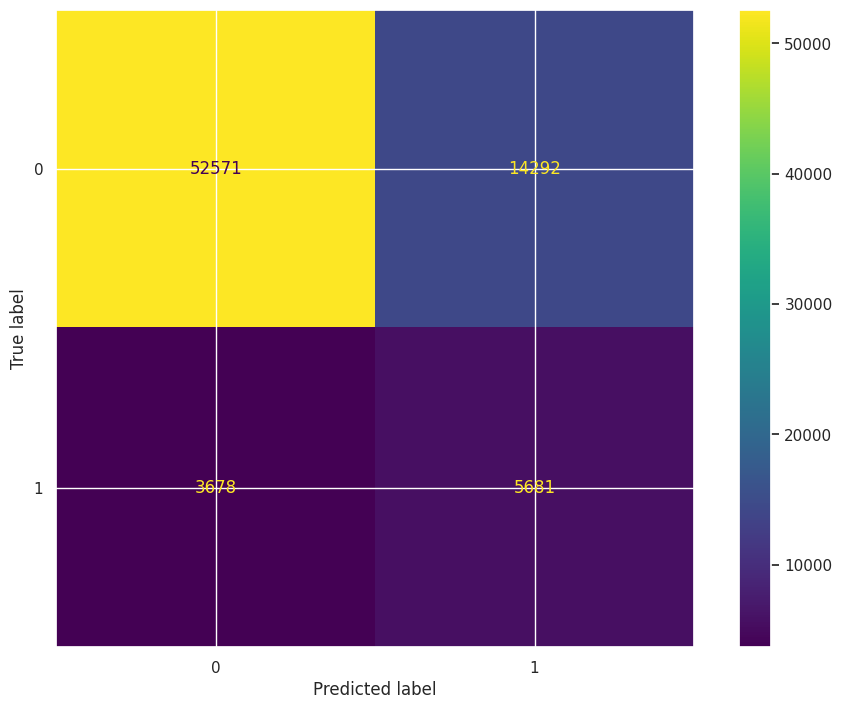

In [ ]:
ConfusionMatrixDisplay(dTree1_cm).plot()

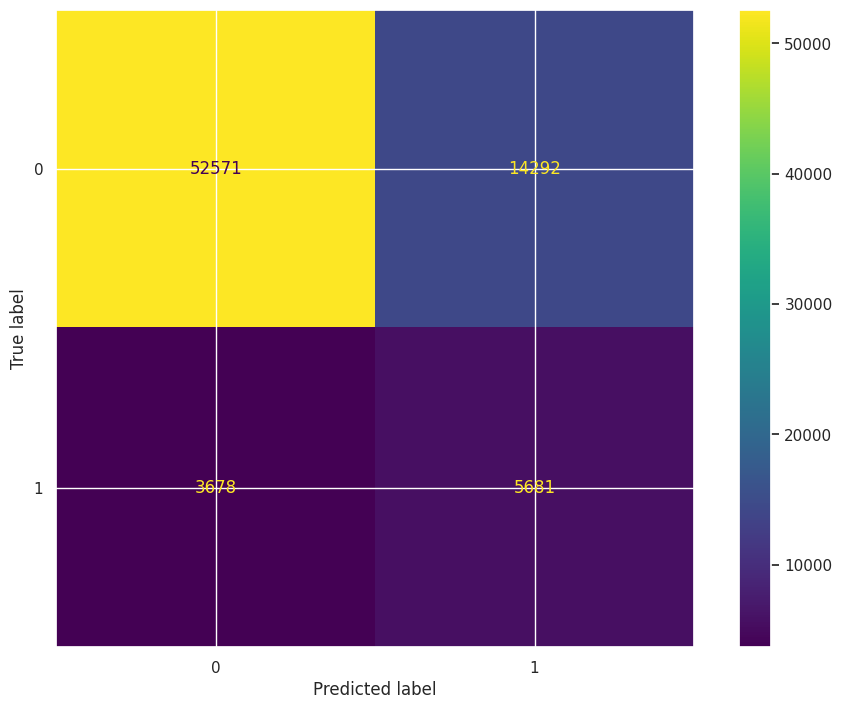

In [ ]:
ConfusionMatrixDisplay(dTree2_cm).plot()

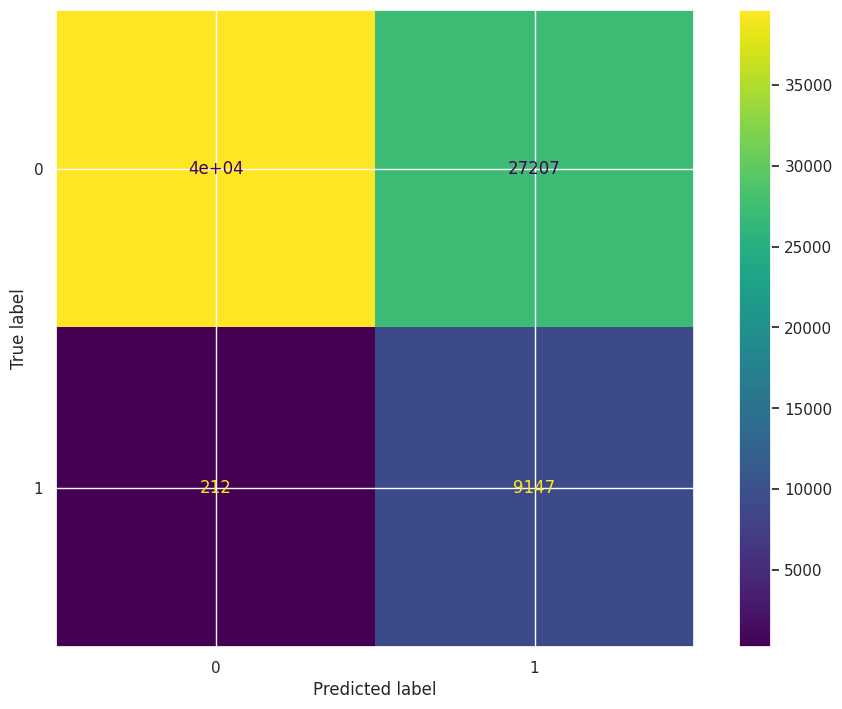

In [ ]:
ConfusionMatrixDisplay(log1_cm).plot()

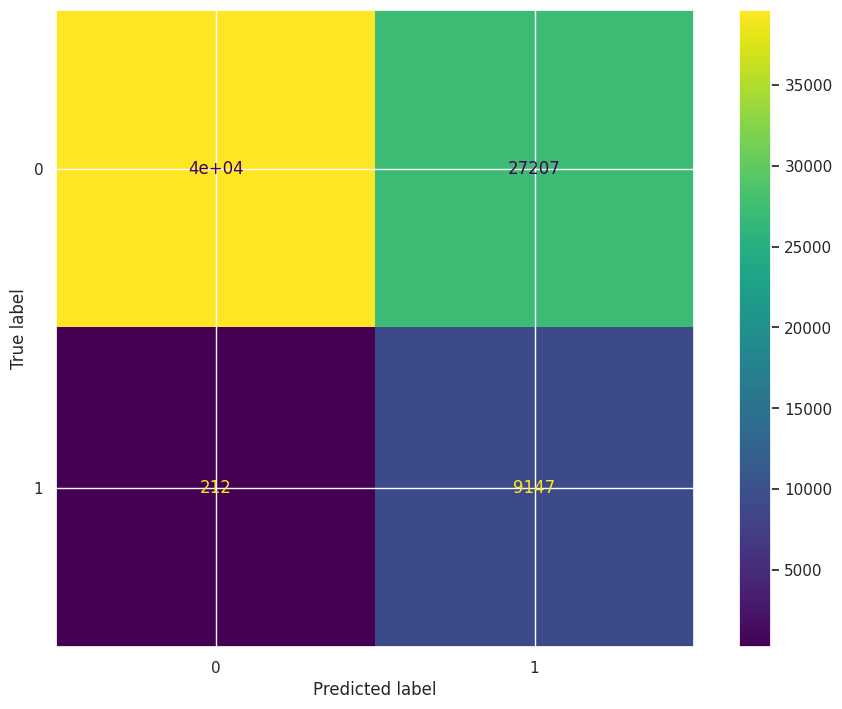

In [ ]:
ConfusionMatrixDisplay(log2_cm).plot()

# **Summary**

In this project, I was tasked with building a model that predicts which customers of an insurance company would be interested in purchasing vehicle insurance. I used demographic information, vehicle details, and policy data as features to build and train the models.

Before building the models, I performed hyperparameter tuning on both the decision tree and logistic regression classifiers. The best and next best parameters obtained from the hyperparameter tuning were used to build and train the models. I evaluated the models using different metrics, focusing on the AUC metric due to class imbalance.

The decision tree classifiers had an AUC score of 0.6966293955507357, while the logistic regression classifier had an AUC score of 0.7839449889053152. The accuracy score for both decision tree classifiers and the logistic regression classifier was around 64%. The precision score for both decision tree classifiers and the logistic regression classifier was around 25%, while the recall score was around 60%. The F1 score for both decision tree classifiers and the logistic regression classifier was around 39% and 40%, respectively.

The confusion matrix for the decision tree classifiers and logistic regression classifier showed that the models had a high number of false positives and false negatives, indicating that there is room for improvement in the models.

Based on the analysis, I recommend that the insurance company use the logistic regression classifier as it had a higher AUC score compared to the decision tree classifiers. However, I suggest that they continue to work on improving the models, perhaps by collecting more relevant data or using more sophisticated techniques like ensemble methods.